# Superset 200 results

Output files location: `gentime-attraction/scripts/` or `nb12_output`

Current outputted files (.tsv): `results-imb-Ne-1000`, `results-imb-Ne-100000`, `results-imb-gt-1000`, `results-imb-gt-100000`

Output file format:
1. "nloci" = given param
2. "nsites" = given param
3. "rep" = counter
4. "concat_tree_raxml" = gene tree newick -> CLOUD TREE
5. "prop_genealogies_concordant" = true genealogy prop concordant -> REPORT # WITH CLOUD TREE
6. "prop_raxtrees_concordant" = gene tree prop concordant -> REPORT # WITH CLOUD TREE
7. "nsnps_per_locus" = #
8. "mean_unique_topologies_per_locus" = #
9. "n_unique_inferred_topologies"= #
10. "astral_tree_genealogies" = true genealogy -> infer species tree newick -> CLOUD TREE
11. "dist_astral_tree_genealogies" = true genealogy -> infer species tree vs. original species tree dist -> USE COLORS ON CLOUD TREE
12. "astral_tree_raxtrees" = gene tree -> infer species tree newick -> CLOUD TREE
13. "dist_astral_tree_raxtrees" = gene tree -> infer species tree vs. original species tree dist -> USE COLORS ON CLOUD TREE
14. "snaq_net1_genealogies" = true genealogy -> network -> PLOT NETWORKS
15. "snaq_net1_genealogies_loglik_diff" = true genealogy -> network snaq loglik diff -> PLOT HISTOGRAM
16. "snaq_net1_raxtrees" = gene tree -> network -> PLOT NETWORKS
17. "snaq_net1_raxtrees_loglik_diff" = gene tree -> network snaq loglik diff -> PLOT HISTOGRAM

Questions: 
- data
    - 198? 185? not 200 for each set
- cloud trees
    - using cloud trees for non-ultrametric trees
    - fixed order doesn't work for cloud trees?
    - method 1 vs. 2

## Load data

In [10]:
import toytree
import pandas as pd
import numpy as np
import ipcoal
import toyplot
import toyplot.svg, toyplot.color

In [224]:
# get an ultrametric imbalanced tree
IMBTREE = toytree.rtree.imbtree(8, treeheight=1e6)
EDGES = [3, 4, 10, 11]
# EDGES = [0, 1, 2, 6, 7, 8, 9, 13, 14]
NE_DEFAULT = 5e5
GT_DEFAULT = 1
RNG = np.random.default_rng(123)
NLOCI = 10_000
NAME_ORDER = sorted(IMBTREE.get_tip_labels())[::-1]
NAME_ORDER 

['r7', 'r6', 'r5', 'r4', 'r3', 'r2', 'r1', 'r0']

In [225]:
# set parameters on the species tree
imbtree_ne = IMBTREE.copy()
imbtree_ne = imbtree_ne.set_node_data("Ne", {i: NE_DEFAULT * 20 for i in EDGES}, default=NE_DEFAULT)
imbtree_ne = imbtree_ne.set_node_data("gt", default=GT_DEFAULT)
imbtree_ne = imbtree_ne.set_node_data("tg", {i: i.dist / i.gt for i in imbtree_ne})
imbtree_ne = imbtree_ne.set_node_data("tc", {i: i.tg / (2 * i.Ne) for i in imbtree_ne})
imbtree_ne = imbtree_ne.set_node_data("theta", {i: 4 * i.Ne * 1e-8 for i in imbtree_ne})
imbtree_ne = imbtree_ne.set_node_data("rho", {i: 4 * i.Ne * 1e-9 for i in imbtree_ne})
imbtree_ne = imbtree_ne.set_node_data("tg_rho", {i: i.tg * i.rho for i in imbtree_ne})
imbtree_ne = imbtree_ne.set_node_data("tg_theta", {i: i.tg * i.theta * 1e-9 for i in imbtree_ne})

# convert edge lens to units of generations.
imbtree_ne = imbtree_ne.set_node_data("dist", {i: i.tg for i in imbtree_ne})

# show data
imbtree_ne.get_node_data()

idx name        height          dist  support          Ne  gt    rho  \
0     0   r0  1.164153e-10  1.428571e+05      NaN    500000.0   1  0.002   
1     1   r1  1.164153e-10  1.428571e+05      NaN    500000.0   1  0.002   
2     2   r2  1.164153e-10  2.857143e+05      NaN    500000.0   1  0.002   
3     3   r3  0.000000e+00  4.285714e+05      NaN  10000000.0   1  0.040   
4     4   r4  0.000000e+00  5.714286e+05      NaN  10000000.0   1  0.040   
5     5   r5  1.164153e-10  7.142857e+05      NaN    500000.0   1  0.002   
6     6   r6  0.000000e+00  8.571429e+05      NaN    500000.0   1  0.002   
7     7   r7  0.000000e+00  1.000000e+06      NaN    500000.0   1  0.002   
8     8       1.428571e+05  1.428571e+05      NaN    500000.0   1  0.002   
9     9       2.857143e+05  1.428571e+05      NaN    500000.0   1  0.002   
10   10       4.285714e+05  1.428571e+05      NaN  10000000.0   1  0.040   
11   11       5.714286e+05  1.428571e+05      NaN  10000000.0   1  0.040   
12   12       7.142857e+05  1.428571e+05      NaN    500000.0   1  0.002   
13   13       8.571429e+05  1.428571e+05      NaN    500000.0   1  0.002   
14   14       1.000000e+06  0.000000e+00      NaN    500000.0   1  0.002   

          tc            tg        tg_rho  tg_theta  theta  
0   0.142857  1.428571e+05    285.714286  0.000003   0.02  
1   0.142857  1.428571e+05    285.714286  0.000003   0.02  
2   0.285714  2.857143e+05    571.428571  0.000006   0.02  
3   0.021429  4.285714e+05  17142.857143  0.000171   0.40  
4   0.028571  5.714286e+05  22857.142857  0.000229   0.40  
5   0.714286  7.142857e+05   1428.571429  0.000014   0.02  
6   0.857143  8.571429e+05   1714.285714  0.000017   0.02  
7   1.000000  1.000000e+06   2000.000000  0.000020   0.02  
8   0.142857  1.428571e+05    285.714286  0.000003   0.02  
9   0.142857  1.428571e+05    285.714286  0.000003   0.02  
10  0.007143  1.428571e+05   5714.285714  0.000057   0.40  
11  0.007143  1.428571e+05   5714.285714  0.000057   0.40  
12  0.142857  1.428571e+05    285.714286  0.000003   0.02  
13  0.142857  1.428571e+05    285.714286  0.000003   0.02  
14  0.000000  0.000000e+00      0.000000  0.000000   0.02

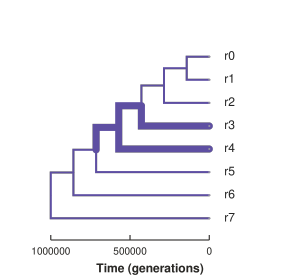

In [228]:
# draw tree figure and save it
kwargs = dict(
    scale_bar=True, tip_labels_align=True, 
    edge_widths=("Ne", 2, 7), edge_colors="gt", fixed_order=NAME_ORDER
)
c, a, m = imbtree_ne.ladderize().draw(**kwargs)
a.x.label.text = "Time (generations)"
toyplot.svg.render(c, "./nb12_output/tree-imb-ne-gunits.svg")
c

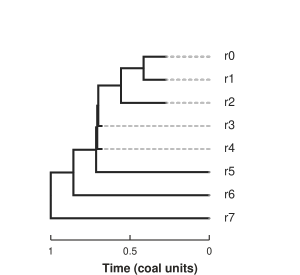

In [230]:
# draw tree w/ edge lengths in coal units
kwargs = dict(scale_bar=True, tip_labels_align=True, fixed_order=NAME_ORDER)
c, a, m = imbtree_ne.set_node_data("dist", {i: i.tc for i in imbtree_ne}).ladderize().draw(**kwargs);
a.x.label.text = "Time (coal units)"
toyplot.svg.render(c, "./nb12_output/tree-imb-ne-cunits.svg")
c

In [231]:
imbtree_gt = IMBTREE.copy()
imbtree_gt = imbtree_gt.set_node_data("Ne", default=NE_DEFAULT)
imbtree_gt = imbtree_gt.set_node_data("gt", {i: GT_DEFAULT * 20 for i in EDGES}, default=GT_DEFAULT)
imbtree_gt = imbtree_gt.set_node_data("tg", {i: i.dist / i.gt for i in imbtree_gt})
imbtree_gt = imbtree_gt.set_node_data("tc", {i: i.tg / (2 * i.Ne) for i in imbtree_gt})
imbtree_gt = imbtree_gt.set_node_data("theta", {i: 4 * i.Ne * 1e-8 for i in imbtree_gt})
imbtree_gt = imbtree_gt.set_node_data("rho", {i: 4 * i.Ne * 1e-9 for i in imbtree_gt})
imbtree_gt = imbtree_gt.set_node_data("tg_rho", {i: i.tg * i.rho for i in imbtree_gt})
imbtree_gt = imbtree_gt.set_node_data("tg_theta", {i: i.tg * i.theta * 1e-9 for i in imbtree_gt})

# convert dist to units of generations. Draw and show data
imbtree_gt = imbtree_gt.set_node_data("dist", {i: i.tg for i in imbtree_gt})
imbtree_gt.get_node_data()

idx name        height          dist  support        Ne  gt    rho  \
0     0   r0  2.714286e+05  1.428571e+05      NaN  500000.0   1  0.002   
1     1   r1  2.714286e+05  1.428571e+05      NaN  500000.0   1  0.002   
2     2   r2  2.714286e+05  2.857143e+05      NaN  500000.0   1  0.002   
3     3   r3  6.785714e+05  2.142857e+04      NaN  500000.0  20  0.002   
4     4   r4  6.785714e+05  2.857143e+04      NaN  500000.0  20  0.002   
5     5   r5  1.164153e-10  7.142857e+05      NaN  500000.0   1  0.002   
6     6   r6  0.000000e+00  8.571429e+05      NaN  500000.0   1  0.002   
7     7   r7  0.000000e+00  1.000000e+06      NaN  500000.0   1  0.002   
8     8       4.142857e+05  1.428571e+05      NaN  500000.0   1  0.002   
9     9       5.571429e+05  1.428571e+05      NaN  500000.0   1  0.002   
10   10       7.000000e+05  7.142857e+03      NaN  500000.0  20  0.002   
11   11       7.071429e+05  7.142857e+03      NaN  500000.0  20  0.002   
12   12       7.142857e+05  1.428571e+05      NaN  500000.0   1  0.002   
13   13       8.571429e+05  1.428571e+05      NaN  500000.0   1  0.002   
14   14       1.000000e+06  0.000000e+00      NaN  500000.0   1  0.002   

          tc            tg       tg_rho      tg_theta  theta  
0   0.142857  1.428571e+05   285.714286  2.857143e-06   0.02  
1   0.142857  1.428571e+05   285.714286  2.857143e-06   0.02  
2   0.285714  2.857143e+05   571.428571  5.714286e-06   0.02  
3   0.021429  2.142857e+04    42.857143  4.285714e-07   0.02  
4   0.028571  2.857143e+04    57.142857  5.714286e-07   0.02  
5   0.714286  7.142857e+05  1428.571429  1.428571e-05   0.02  
6   0.857143  8.571429e+05  1714.285714  1.714286e-05   0.02  
7   1.000000  1.000000e+06  2000.000000  2.000000e-05   0.02  
8   0.142857  1.428571e+05   285.714286  2.857143e-06   0.02  
9   0.142857  1.428571e+05   285.714286  2.857143e-06   0.02  
10  0.007143  7.142857e+03    14.285714  1.428571e-07   0.02  
11  0.007143  7.142857e+03    14.285714  1.428571e-07   0.02  
12  0.142857  1.428571e+05   285.714286  2.857143e-06   0.02  
13  0.142857  1.428571e+05   285.714286  2.857143e-06   0.02  
14  0.000000  0.000000e+00     0.000000  0.000000e+00   0.02

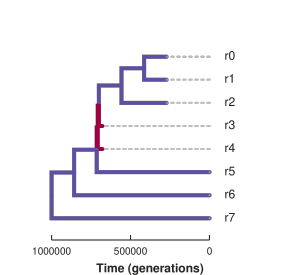

In [234]:
# draw tree figure and save it
kwargs = dict(
    scale_bar=True, tip_labels_align=True, 
    edge_widths=("Ne", 2, 4), edge_colors="gt",
    fixed_order=NAME_ORDER
)
c, a, m = imbtree_gt.ladderize().draw(**kwargs);
a.x.label.text = "Time (generations)"
toyplot.svg.render(c, "./nb12_output/tree-imb-gt-gunits.svg")
c

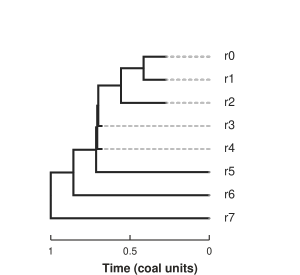

In [235]:
# draw tree w/ edge lengths in coal units
kwargs = dict(scale_bar=True, tip_labels_align=True, fixed_order=NAME_ORDER)
c, a, m = imbtree_gt.set_node_data("dist", {i: i.tc for i in imbtree_gt}).ladderize().draw(**kwargs);
a.x.label.text = "Time (coal units)"
toyplot.svg.render(c, "./nb12_output/tree-imb-gt-cunits.svg")
c

In [17]:
# import tsv supersets
tsv_header = ["nloci",
        "nsites",
        "rep",
        "concat_tree_raxml",
        "prop_genealogies_concordant",
        "prop_raxtrees_concordant",
        "nsnps_per_locus",
        "mean_unique_topologies_per_locus",
        "n_unique_inferred_topologies",
        "astral_tree_genealogies",
        "dist_astral_tree_genealogies",
        "astral_tree_raxtrees",
        "dist_astral_tree_raxtrees",
        "snaq_net1_genealogies",
        "snaq_net1_genealogies_loglik_diff",
        "snaq_net1_raxtrees",
        "snaq_net1_raxtrees_loglik_diff"]

superset_imb_Ne_1000 = pd.read_csv('/home/scarlet/scratch/gentime-attraction/scripts/results-imb-Ne-1000/superset-imb-Ne-1000.tsv', sep='\t', names=tsv_header)
superset_imb_Ne_100000 = pd.read_csv('/home/scarlet/scratch/gentime-attraction/scripts/results-imb-Ne-100000/superset-imb-Ne-100000.tsv', sep='\t', names=tsv_header)
superset_imb_gt_1000 = pd.read_csv('/home/scarlet/scratch/gentime-attraction/scripts/results-imb-gt-1000/superset-imb-gt-1000.tsv', sep='\t', names=tsv_header)
superset_imb_gt_100000 = pd.read_csv('/home/scarlet/scratch/gentime-attraction/scripts/results-imb-gt-100000/superset-imb-gt-100000.tsv',sep='\t', names=tsv_header)

In [41]:
superset_imb_Ne_1000

nloci  nsites  rep            concat_tree_raxml  \
0    10000.0  1000.0    0  (((r4:0.01863,r3:0.01850...   
1    10000.0  1000.0    1  (((r6:0.020421,r7:0.0239...   
2    10000.0  1000.0    2  ((r1:0.014475,r0:0.01447...   
3    10000.0  1000.0    3  (((r5:0.018815,r3:0.0186...   
4    10000.0  1000.0    4  (r2:0.017409,(r1:0.01460...   
..       ...     ...  ...                          ...   
193  10000.0  1000.0  195  (r2:0.017596,(r0:0.01465...   
194  10000.0  1000.0  196  (((((r0:0.014503,r1:0.01...   
195  10000.0  1000.0  197  (((r5:0.019576,((r7:0.02...   
196  10000.0  1000.0  198  (r7:0.023917,((r5:0.0186...   
197  10000.0  1000.0  199  (r7:0.023776,((r3:0.0189...   

     prop_genealogies_concordant  prop_raxtrees_concordant  nsnps_per_locus  \
0                         0.0005                    0.0002         106.6799   
1                         0.0002                    0.0002         106.7757   
2                         0.0001                    0.0002         106.6098   
3                         0.0004                    0.0004         107.1722   
4                         0.0002                    0.0002         106.8312   
..                           ...                       ...              ...   
193                       0.0005                    0.0006         107.0363   
194                       0.0002                    0.0004         107.2506   
195                       0.0008                    0.0001         107.0965   
196                       0.0008                    0.0003         106.8336   
197                       0.0004                    0.0003         106.6093   

     mean_unique_topologies_per_locus  n_unique_inferred_topologies  \
0                         5.6777                              7299    
1                         5.7313                              7315    
2                         5.6501                              7225    
3                         5.6689                              7272    
4                         5.7251                              7223    
..                           ...                               ...    
193                       5.7146                              7315    
194                       5.7208                              7242    
195                       5.7041                              7276    
196                       5.6999                              7239    
197                       5.6775                              7305    

         astral_tree_genealogies  dist_astral_tree_genealogies  \
0    (r7:1,(r6:1,(r4:1,(r5:1,...                            2    
1    (r3:1,(r4:1,((r5:1,(r6:1...                            2    
2    (r0:1,(r1:1,(r2:1,(r3:1,...                            0    
3    (r4:1,((r3:1,(r2:1,(r1:1...                            0    
4    (r5:1,((r6:1,r7:1)1:0.14...                            0    
..                           ...                          ...    
193  (r1:1,(r0:1,(r2:1,(r3:1,...                            0    
194  (r7:1,(r6:1,(r5:1,((r3:1...                            0    
195  (r3:1,((r2:1,(r0:1,r1:1)...                            2    
196  (r2:1,((r0:1,r1:1)1:0.13...                            2    
197  (r5:1,((r4:1,(r3:1,(r2:1...                            0    

            astral_tree_raxtrees  dist_astral_tree_raxtrees  \
0    (r5:1,((r4:1,(r3:1,(r2:1...                          0   
1    (r1:1,(r0:1,(r2:1,(r3:1,...                          0   
2    (r1:1,(r0:1,(r2:1,(r4:1,...                          2   
3    (r6:1,(r7:1,(r4:1,(r5:1,...                          2   
4    (r0:1,((r2:1,(r3:1,(r4:1...                          0   
..                           ...                        ...   
193  (r7:1,((r5:1,(r4:1,(r3:1...                          0   
194  (r3:1,((r2:1,(r0:1,r1:1)...                          2   
195  (r4:1,((r3:1,(r2:1,(r1:1...                          0   
196  (r2:1,((r0:1,r1:1)1:0.14...                          2   
197  (r6:1,(r7:1,(r5:1

In [188]:
superset_imb_Ne_100000

nloci    nsites  rep            concat_tree_raxml  \
0    10000.0  100000.0    0  (r0:0.014474,r1:0.014487...   
1    10000.0  100000.0    1  (r6:0.020379,((r5:0.0187...   
2    10000.0  100000.0    2  ((r1:0.014507,r0:0.01461...   
3    10000.0  100000.0    3  ((((r6:0.020421,r7:0.023...   
4    10000.0  100000.0    4  (((r1:0.014485,r0:0.0144...   
..       ...       ...  ...                          ...   
180  10000.0  100000.0  194  (r7:0.023866,(r5:0.01976...   
181  10000.0  100000.0  195  ((((r6:0.020459,r7:0.023...   
182  10000.0  100000.0  196  (r4:0.018619,r3:0.018637...   
183  10000.0  100000.0  197  ((r1:0.014506,r0:0.01443...   
184  10000.0  100000.0  198  ((r1:0.014479,r0:0.01442...   

     prop_genealogies_concordant  prop_raxtrees_concordant  nsnps_per_locus  \
0                         0.0008                    0.0120       10693.6951   
1                         0.0002                    0.0116       10697.2334   
2                         0.0007                    0.0130       10694.8704   
3                         0.0004                    0.0128       10691.7140   
4                         0.0003                    0.0126       10693.4429   
..                           ...                       ...              ...   
180                       0.0003                    0.0131       10697.5661   
181                       0.0004                    0.0132       10696.3525   
182                       0.0007                    0.0125       10686.9559   
183                       0.0004                    0.0133       10690.5195   
184                       0.0002                    0.0126       10695.2741   

     mean_unique_topologies_per_locus  n_unique_inferred_topologies  \
0                       436.9617                              1731    
1                       436.8663                              1774    
2                       437.1479                              1774    
3                       436.6644                              1719    
4                       436.7241                              1760    
..                           ...                               ...    
180                     437.0599                              1730    
181                     437.1289                              1776    
182                     436.6230                              1769    
183                     437.0093                              1741    
184                     436.4523                              1768    

         astral_tree_genealogies  dist_astral_tree_genealogies  \
0    (r7:1,(r6:1,(r5:1,(r4:1,...                            0    
1    (r0:1,((r2:1,((r6:1,r7:1...                            4    
2    (r5:1,((r6:1,r7:1)1:0.14...                            0    
3    (r1:1,(r0:1,(r2:1,(r3:1,...                            0    
4    (r4:1,((r5:1,(r6:1,r7:1)...                            0    
..                           ...                          ...    
180  (r2:1,((r3:1,(r4:1,(r5:1...                            0    
181  (r0:1,(r1:1,((r4:1,(r3:1...                            2    
182  (r0:1,(r1:1,(r2:1,(r3:1,...                            0    
183  (r6:1,(r7:1,(r5:1,(r4:1,...                            0    
184  (r5:1,(((r3:1,r4:1)0.47:...                            2    

            astral_tree_raxtrees  dist_astral_tree_raxtrees  \
0    (r0:1,((r2:1,(r3:1,(r4:1...                          0   
1    (r7:1,((r5:1,(r4:1,(r3:1...                          0   
2    (r4:1,((r3:1,(r2:1,(r1:1...                          0   
3    (r0:1,((r2:1,(r3:1,(r4:1...                          0   
4    (r4:1,((r5:1,(r7:1,r6:1)...                          0   
..                           ...                        ...   
180  (r2:1,((r3:1,(r4:1,(r5:1...                          0   
181  (r1:1,(r0:1,((r3:1,(r4:1...                          0   
182  (r7:1,((r5:1,(r4:1,(r3:1...                          0   
183  (r5:1,((r6:1,r7:1)1:0.68...                          0  

## Gene tree inference
## Concat tree raxml -> cloud tree with grayscale representing most freq. gene tree
4. "concat_tree_raxml" = gene tree newick -> CLOUD TREE


### Imb Ne 1000

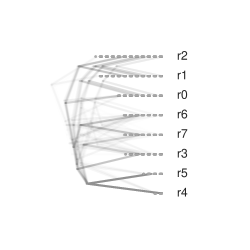

In [437]:
# directly plot cloud tree
superset_imb_Ne_1000_concat_tree_raxml = toytree.mtree(superset_imb_Ne_1000.concat_tree_raxml)
c, a, m = superset_imb_Ne_1000_concat_tree_raxml.draw_cloud_tree(height=250, width=250, fixed_order = NAME_ORDER, tip_labels_align=True);
c

In [358]:
# plot cloud tree by highest freq. unique topology
cmap_cloudtree = toyplot.color.brewer.map("Greys", reverse=True)
cmap_cloudtree

In [359]:
def parse_and_plot_unique_topology_freq_for_cloud_tree(input_col, cmap):
    # parse
    mtree = toytree.mtree(input_col)
    unique_topologies_all_data = mtree.get_unique_topologies()
    unique_topologies = []
    unique_topologies_stroke_opacities = []
    
    for unique_topology in unique_topologies_all_data:
        unique_topologies.append(unique_topology[0])
        unique_topologies_stroke_opacities.append(unique_topology[1])
       
    unique_topologies_mtree = toytree.mtree(unique_topologies)
    unique_topologies_stroke_opacities = np.array(unique_topologies_stroke_opacities)
    
    
    # plot
    colors = toyplot.color.broadcast(
        colors=(unique_topologies_stroke_opacities, cmap_cloudtree),
        shape=unique_topologies_stroke_opacities.shape,
    )

    for idx, tree in enumerate(unique_topologies_mtree.treelist):
        tree.style.edge_style["stroke"] = colors[idx]

    c, a, m = unique_topologies_mtree.draw_cloud_tree(
        height=250, width=250,
        edge_style={"stroke-opacity": 0.5},
        fixed_order = NAME_ORDER,
        tip_labels_align=True
    );
    
    return c

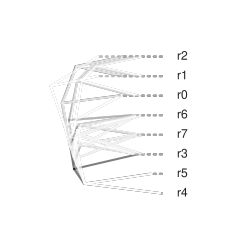

In [360]:
c = parse_and_plot_unique_topology_freq_for_cloud_tree(superset_imb_Ne_1000.concat_tree_raxml, cmap_cloudtree)
c

### Imb Ne 100000

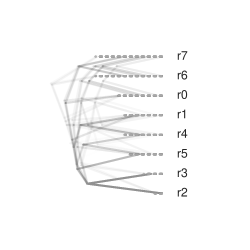

In [361]:
# directly plot cloud tree
superset_imb_Ne_100000_concat_tree_raxml = toytree.mtree(superset_imb_Ne_100000.concat_tree_raxml)
c, a, m = superset_imb_Ne_100000_concat_tree_raxml.draw_cloud_tree(height=250, width=250, fixed_order = NAME_ORDER, tip_labels_align=True);
c

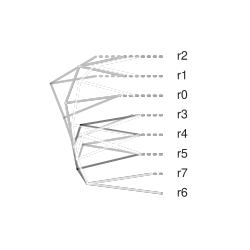

In [362]:
# plot cloud tree by highest freq. unique topology
c = parse_and_plot_unique_topology_freq_for_cloud_tree(superset_imb_Ne_100000.concat_tree_raxml, cmap_cloudtree)
c

### Imb gt 1000

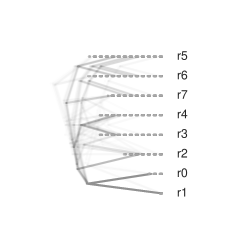

In [363]:
# directly plot cloud tree
superset_imb_gt_1000_concat_tree_raxml = toytree.mtree(superset_imb_gt_1000.concat_tree_raxml)
c, a, m = superset_imb_gt_1000_concat_tree_raxml.draw_cloud_tree(height=250, width=250, fixed_order = NAME_ORDER, tip_labels_align=True);
c

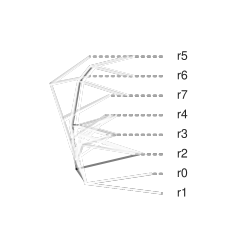

In [364]:
# plot cloud tree by highest freq. unique topology
c = parse_and_plot_unique_topology_freq_for_cloud_tree(superset_imb_gt_1000.concat_tree_raxml, cmap_cloudtree)
c

### Imb gt 100000

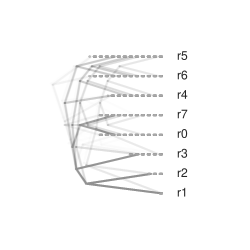

In [365]:
# directly plot cloud tree
superset_imb_gt_100000_concat_tree_raxml = toytree.mtree(superset_imb_gt_100000.concat_tree_raxml)
c, a, m = superset_imb_gt_100000_concat_tree_raxml.draw_cloud_tree(height=250, width=250, fixed_order = NAME_ORDER, tip_labels_align=True);
c

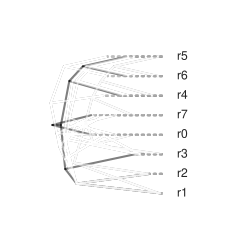

In [366]:
# plot cloud tree by highest freq. unique topology
c = parse_and_plot_unique_topology_freq_for_cloud_tree(superset_imb_gt_100000.concat_tree_raxml, cmap_cloudtree)
c

## Gene tree stats

5. "prop_genealogies_concordant" = true genealogy prop concordant -> REPORT # WITH CLOUD TREE
6. "prop_raxtrees_concordant" = gene tree prop concordant -> REPORT # WITH CLOUD TREE
7. "nsnps_per_locus" = #
8. "mean_unique_topologies_per_locus" = #
9. "n_unique_inferred_topologies"= #

In [438]:
def print_gene_tree_stats(input_df):
    print("prop. genealogies concordant: ", "{:.4f}".format(np.mean(input_df.prop_genealogies_concordant))) 
    print("prop. raxtrees concordant: ", "{:.4f}".format(np.mean(input_df.prop_raxtrees_concordant))) 
    print("nsnps per locus: ", "{:.0f}".format(np.mean(input_df.nsnps_per_locus))) 
    print("mean unique topologies per locus: ", "{:.0f}".format(np.mean(input_df.mean_unique_topologies_per_locus))) 
    print("# unique inferred topologies: ", "{:.0f}".format(np.mean(input_df.n_unique_inferred_topologies))) 

### Imb Ne 1000

In [439]:
print_gene_tree_stats(superset_imb_Ne_1000)

prop. genealogies concordant:  0.0005
prop. raxtrees concordant:  0.0003
nsnps per locus:  107
mean unique topologies per locus:  6
# unique inferred topologies:  7252


### Imb Ne 100000

In [440]:
print_gene_tree_stats(superset_imb_Ne_100000)

prop. genealogies concordant:  0.0005
prop. raxtrees concordant:  0.0129
nsnps per locus:  10693
mean unique topologies per locus:  437
# unique inferred topologies:  1759


### Imb gt 1000

In [441]:
print_gene_tree_stats(superset_imb_gt_1000)

prop. genealogies concordant:  0.0005
prop. raxtrees concordant:  0.0002
nsnps per locus:  89
mean unique topologies per locus:  4
# unique inferred topologies:  7335


### Imb gt 100000

In [442]:
print_gene_tree_stats(superset_imb_gt_100000)

prop. genealogies concordant:  0.0005
prop. raxtrees concordant:  0.0040
nsnps per locus:  8860
mean unique topologies per locus:  299
# unique inferred topologies:  2570


## Species tree inference

10. "astral_tree_genealogies" = true genealogy -> infer species tree newick -> CLOUD TREE
11. "dist_astral_tree_genealogies" = true genealogy -> infer species tree vs. original species tree dist -> USE COLORS ON CLOUD TREE
12. "astral_tree_raxtrees" = gene tree -> infer species tree newick -> CLOUD TREE
13. "dist_astral_tree_raxtrees" = gene tree -> infer species tree vs. original species tree dist -> USE COLORS ON CLOUD TREE

In [403]:
cmap_dist_cloudtree = toyplot.color.brewer.map("Reds", domain_min=0, domain_max=4)
cmap_dist_cloudtree.colors([0, 1, 2, 3, 4])

array([(0.40392157, 0.        , 0.05098039, 1.),
       (0.79607843, 0.09411765, 0.11372549, 1.),
       (0.98431373, 0.41568627, 0.29019608, 1.),
       (0.98823529, 0.73333333, 0.63137255, 1.),
       (1.        , 0.96078431, 0.94117647, 1.)],
      dtype=[('r', '<f8'), ('g', '<f8'), ('b', '<f8'), ('a', '<f8')])

In [387]:
def plot_dist_color_for_cloud_tree(input_trees, input_dists, cmap):    
    input_mtree = toytree.mtree(input_trees)
    input_dists = np.array(input_dists)
    # plot
    colors = toyplot.color.broadcast(
        colors=(input_dists, cmap),
        shape=input_dists.shape,
    )

    for idx, tree in enumerate(input_mtree.treelist):
        tree.style.edge_style["stroke"] = colors[idx]

    c, a, m = input_mtree.draw_cloud_tree(
        height=250, width=250,
        edge_style={"stroke-opacity": 0.05},
        fixed_order = NAME_ORDER,
        tip_labels_align=True
    );
    
    return c

### Imb Ne 1000

#### dist astral genealogies

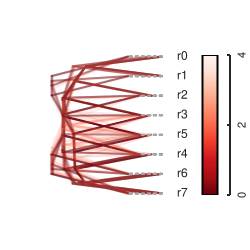

In [409]:
c = plot_dist_color_for_cloud_tree(superset_imb_Ne_1000.astral_tree_genealogies, 
                                   superset_imb_Ne_1000.dist_astral_tree_genealogies,
                                   cmap_dist_cloudtree)
numberline = c.numberline(210, 195, 210, 55, min=0, max=0.5)
numberline.colormap(cmap_dist_cloudtree, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0, 2, 4], labels=[0, 2, 4])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
toyplot.svg.render(c, "./nb12_output/plot-cloudtree-dist-astral-genealogies-superset200-variable-ne-1e3-imb.svg")
c

#### dist astral raxtrees

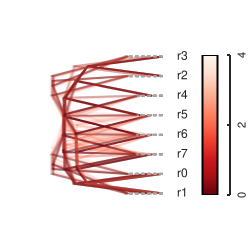

In [410]:
c = plot_dist_color_for_cloud_tree(superset_imb_Ne_1000.astral_tree_raxtrees, 
                                   superset_imb_Ne_1000.dist_astral_tree_raxtrees,
                                   cmap_dist_cloudtree)
numberline = c.numberline(210, 195, 210, 55, min=0, max=0.5)
numberline.colormap(cmap_dist_cloudtree, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0, 2, 4], labels=[0, 2, 4])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
toyplot.svg.render(c, "./nb12_output/plot-cloudtree-dist-astral-raxtrees-superset200-variable-ne-1e3-imb.svg")
c

### Imb Ne 100000

#### dist astral genealogies

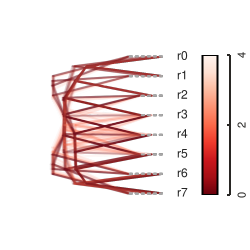

In [411]:
c = plot_dist_color_for_cloud_tree(superset_imb_Ne_100000.astral_tree_genealogies, 
                                   superset_imb_Ne_100000.dist_astral_tree_genealogies,
                                   cmap_dist_cloudtree)
numberline = c.numberline(210, 195, 210, 55, min=0, max=0.5)
numberline.colormap(cmap_dist_cloudtree, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0, 2, 4], labels=[0, 2, 4])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
toyplot.svg.render(c, "./nb12_output/plot-cloudtree-dist-astral-genealogies-superset200-variable-ne-1e5-imb.svg")
c

#### dist astral raxtrees

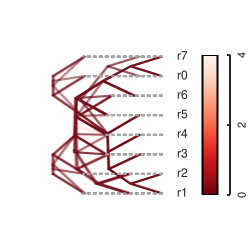

In [412]:
c = plot_dist_color_for_cloud_tree(superset_imb_Ne_100000.astral_tree_raxtrees, 
                                   superset_imb_Ne_100000.dist_astral_tree_raxtrees,
                                   cmap_dist_cloudtree)
numberline = c.numberline(210, 195, 210, 55, min=0, max=0.5)
numberline.colormap(cmap_dist_cloudtree, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0, 2, 4], labels=[0, 2, 4])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
toyplot.svg.render(c, "./nb12_output/plot-cloudtree-dist-astral-raxtrees-superset200-variable-ne-1e5-imb.svg")
c

### Imb gt 1000

#### dist astral genealogies

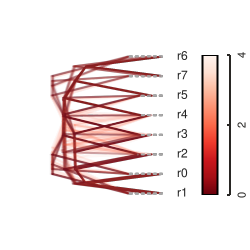

In [413]:
c = plot_dist_color_for_cloud_tree(superset_imb_gt_1000.astral_tree_genealogies, 
                                   superset_imb_gt_1000.dist_astral_tree_genealogies,
                                   cmap_dist_cloudtree)
numberline = c.numberline(210, 195, 210, 55, min=0, max=0.5)
numberline.colormap(cmap_dist_cloudtree, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0, 2, 4], labels=[0, 2, 4])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
toyplot.svg.render(c, "./nb12_output/plot-cloudtree-dist-astral-genealogies-superset200-variable-gt-1e3-imb.svg")
c

#### dist astral raxtrees

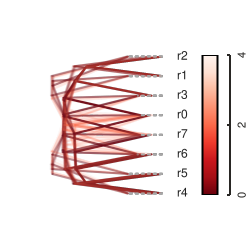

In [414]:
c = plot_dist_color_for_cloud_tree(superset_imb_gt_1000.astral_tree_raxtrees, 
                                   superset_imb_gt_1000.dist_astral_tree_raxtrees,
                                   cmap_dist_cloudtree)
numberline = c.numberline(210, 195, 210, 55, min=0, max=0.5)
numberline.colormap(cmap_dist_cloudtree, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0, 2, 4], labels=[0, 2, 4])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
toyplot.svg.render(c, "./nb12_output/plot-cloudtree-dist-astral-raxtrees-superset200-variable-gt-1e3-imb.svg")
c

### Imb gt 100000

#### dist astral genealogies

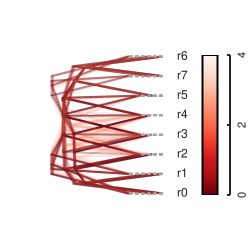

In [415]:
c = plot_dist_color_for_cloud_tree(superset_imb_gt_100000.astral_tree_genealogies, 
                                   superset_imb_gt_100000.dist_astral_tree_genealogies,
                                   cmap_dist_cloudtree)
numberline = c.numberline(210, 195, 210, 55, min=0, max=0.5)
numberline.colormap(cmap_dist_cloudtree, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0, 2, 4], labels=[0, 2, 4])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
toyplot.svg.render(c, "./nb12_output/plot-cloudtree-dist-astral-genealogies-superset200-variable-gt-1e5-imb.svg")
c

#### dist astral raxtrees

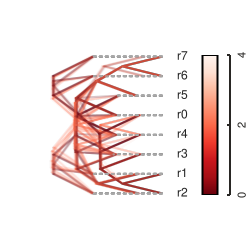

In [416]:
c = plot_dist_color_for_cloud_tree(superset_imb_gt_100000.astral_tree_raxtrees, 
                                   superset_imb_gt_100000.dist_astral_tree_raxtrees,
                                   cmap_dist_cloudtree)
numberline = c.numberline(210, 195, 210, 55, min=0, max=0.5)
numberline.colormap(cmap_dist_cloudtree, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0, 2, 4], labels=[0, 2, 4])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
toyplot.svg.render(c, "./nb12_output/plot-cloudtree-dist-astral-raxtrees-superset200-variable-gt-1e5-imb.svg")
c

## Snaq network plots & loglik histograms

14. "snaq_net1_genealogies" = true genealogy -> network -> PLOT NETWORKS
15. "snaq_net1_genealogies_loglik_diff" = true genealogy -> network snaq loglik diff -> PLOT HISTOGRAM
16. "snaq_net1_raxtrees" = gene tree -> network -> PLOT NETWORKS
17. "snaq_net1_raxtrees_loglik_diff" = gene tree -> network snaq loglik diff -> PLOT HISTOGRAM

In [205]:
cmap_snaq = toyplot.color.brewer.map("Spectral", domain_min=0, domain_max=0.5)
cmap_snaq.colors([0.5, 0.4, 0.3, 0.2, 0.1, 0.0])

array([(0.61960784, 0.00392157, 0.25882353, 1.),
       (0.95686275, 0.42745098, 0.2627451 , 1.),
       (0.99607843, 0.87843137, 0.54509804, 1.),
       (0.90196078, 0.96078431, 0.59607843, 1.),
       (0.4       , 0.76078431, 0.64705882, 1.),
       (0.36862745, 0.30980392, 0.63529412, 1.)],
      dtype=[('r', '<f8'), ('g', '<f8'), ('b', '<f8'), ('a', '<f8')])

In [249]:
colors_hist = toyplot.color.brewer.palette("Set2")
colors2_hist = toyplot.color.brewer.palette("Reds")

In [212]:
def parse_networks_tsv(input_col, cmap):
    # store outputs
    tree = []
    admix = []
    src_nodes = []
    dest_nodes = []
    pos_as_props = []
    pos_as_props_rand = []
    gammas = []
    plot_admix = []
    
    # parse each net
    for net in input_col:
        try:
            t, a = toytree.network.parse_network_to_tree_and_admix(net)
            pos_as_prop_rand = np.random.uniform(0,1)
            tree.append(t.write())
            admix.append(a)
            src_node, dest_node, pos_as_prop, style_original, gamma = a[0]
            src_nodes.append(src_node)
            dest_nodes.append(dest_node)
            pos_as_props.append(pos_as_prop)
            gammas.append(float(gamma))
            pos_as_props_rand.append(pos_as_prop_rand)
            plot_a = tuple([src_node, dest_node, pos_as_prop_rand, {"stroke": cmap.colors(gamma),'stroke-opacity':float(gamma)*2, 'stroke-width':2}])
            plot_admix.append(plot_a)
        except:
            tree.append(0)
            admix.append(0)
            src_nodes.append(0)
            dest_nodes.append(0)
            pos_as_props.append(0)
            gammas.append(0)
            plot_admix.append(0)
            pos_as_props_rand.append(0)
    # outputs
    
    out = {'net': input_col,
           'trees': tree,
           'admix': admix,
           'src_node': src_nodes,
           'dest_node': dest_nodes,
           'pos_as_prop': pos_as_props,
           'pos_as_prop_rand': pos_as_props_rand,
           'gamma': gammas,
           'plot_admix': plot_admix
              } 
    # includes 0 entries
    df_out = pd.DataFrame(data=out)
    # excludes 0 entries
    plot_admix_subset = df_out[df_out.admix != 0]
    plot_admix_final = plot_admix_subset.plot_admix.values.tolist()
    
    return df_out, plot_admix_subset, plot_admix_final

In [223]:
def count_alt_topology_prop(parse_df, correct_topology):
    trees = toytree.mtree(parse_df.trees)
    alt_topology_counter = 0
    alt_topology_idxs = []
    major_topology_idxs = []
    for idx, tree in enumerate(trees):
        # quartets do not conflict metric
        qrt = toytree.distance.get_treedist_quartets(tree, correct_topology)[14]
        if(qrt != 0):
            alt_topology_idxs.append(idx)
            alt_topology_counter +=1
        else:
            major_topology_idxs.append(idx)
    
    # output
    alt_topology_out_df = parse_df.iloc[alt_topology_idxs]
    major_topology_out_df = parse_df.iloc[major_topology_idxs]
    alt_topology_prop = alt_topology_counter / len(trees)
    
    return major_topology_out_df, alt_topology_out_df, alt_topology_prop

### Imb Ne 1000

#### Net 1 genealogies

In [262]:
a, b, c = parse_networks_tsv(superset_imb_Ne_1000.snaq_net1_genealogies, cmap_snaq)
d, e, f = count_alt_topology_prop(b, imbtree_ne)
f

0.3756345177664975

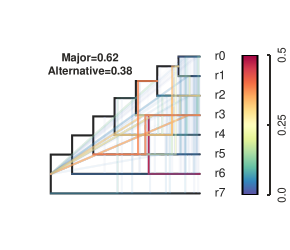

In [263]:
# draw all edges on major networks
c, a, m = IMBTREE.draw(height=250, width=290, admixture_edges=d.plot_admix.to_list(),
                      fixed_order = NAME_ORDER);
# add colorbar
numberline = c.numberline(250, 195, 250, 55, min=0, max=0.5)
numberline.colormap(cmap_snaq, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0.0, 0.25, 0.50], labels=[0.0, 0.25, 0.50])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
# add text major vs. alternative network topology
c.text(90,65,
    "<b>Major=0.62</b><br/><b>Alternative=0.38</b>",
    style={"font-size":"11px"},
);
toyplot.svg.render(c, "./nb12_output/plot-net1genealogies-superset200-variable-ne-1e3-imb.svg")
c

In [264]:
# compute means
hist_major_mean = np.mean(d.gamma[d["gamma"] != 0].values)
hist_minor_mean = np.mean(e.gamma[e["gamma"] != 0].values)
print(hist_major_mean, hist_minor_mean)

0.06743048780487805 0.10990081081081081


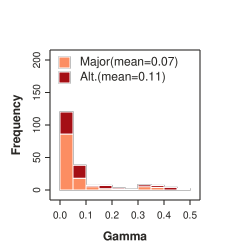

In [265]:
# stacked version
hist_major = np.histogram(d.gamma[d["gamma"] != 0].values, range=(0, 0.5), bins=10)
hist_minor = np.histogram(e.gamma[e["gamma"] != 0].values, range=(0, 0.5), bins=10)
major_minor_stack_counts = np.column_stack((hist_major[0], hist_minor[0]))

c = toyplot.Canvas(width=250, height=250)
a = c.cartesian()
bars = a.bars((major_minor_stack_counts), 
              along="x",
              color=[colors_hist[1], colors2_hist[1]])
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
a.x.ticks.locator = toyplot.locator.Explicit(locations=[-0.5,1.5,3.5,5.5,7.5,9.5], labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
c.style["stroke.width"]=8
a.y.domain.max=200
c.legend([
    ("Major(mean=0.07)", bars.markers[0]),
    ("Alt.(mean=0.11)", bars.markers[1]),
    ],
    bounds=(70, 80, 55, 85),
    );
toyplot.svg.render(c, "./nb12_output/plot-net1genealogies-superset200-hist-gamma-variable-ne-1e3-imb.svg")
c

#### Net 1 raxtrees

In [266]:
a, b, c = parse_networks_tsv(superset_imb_Ne_1000.snaq_net1_raxtrees, cmap_snaq)
d, e, f = count_alt_topology_prop(b, imbtree_ne)
f

0.39896373056994816

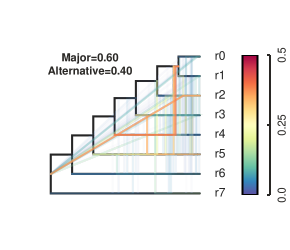

In [267]:
# draw all edges on major networks
c, a, m = IMBTREE.draw(height=250, width=290, admixture_edges=d.plot_admix.to_list(),
                      fixed_order = NAME_ORDER);
# add colorbar
numberline = c.numberline(250, 195, 250, 55, min=0, max=0.5)
numberline.colormap(cmap_snaq, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0.0, 0.25, 0.50], labels=[0.0, 0.25, 0.50])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
# add text major vs. alternative network topology
c.text(90,65,
    "<b>Major=0.60</b><br/><b>Alternative=0.40</b>",
    style={"font-size":"11px"},
);
toyplot.svg.render(c, "./nb12_output/plot-net1raxtrees-superset200-variable-ne-1e3-imb.svg")
c

In [268]:
# compute means
hist_major_mean = np.mean(d.gamma[d["gamma"] != 0].values)
hist_minor_mean = np.mean(e.gamma[e["gamma"] != 0].values)
print(hist_major_mean, hist_minor_mean)

0.06568301724137932 0.08340532467532469


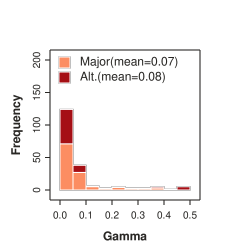

In [269]:
# stacked version
hist_major = np.histogram(d.gamma[d["gamma"] != 0].values, range=(0, 0.5), bins=10)
hist_minor = np.histogram(e.gamma[e["gamma"] != 0].values, range=(0, 0.5), bins=10)
major_minor_stack_counts = np.column_stack((hist_major[0], hist_minor[0]))

c = toyplot.Canvas(width=250, height=250)
a = c.cartesian()
bars = a.bars((major_minor_stack_counts), 
              along="x",
              color=[colors_hist[1], colors2_hist[1]])
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
a.x.ticks.locator = toyplot.locator.Explicit(locations=[-0.5,1.5,3.5,5.5,7.5,9.5], labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
c.style["stroke.width"]=8
a.y.domain.max=200
c.legend([
    ("Major(mean=0.07)", bars.markers[0]),
    ("Alt.(mean=0.08)", bars.markers[1]),
    ],
    bounds=(70, 80, 55, 85),
    );
toyplot.svg.render(c, "./nb12_output/plot-net1raxtrees-superset200-hist-gamma-variable-ne-1e3-imb.svg")
c

#### loglik histogram

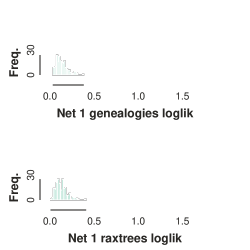

In [340]:
loglik_all = [np.array(superset_imb_Ne_1000.snaq_net1_genealogies_loglik_diff), np.array(superset_imb_Ne_1000.snaq_net1_raxtrees_loglik_diff)]

c = toyplot.Canvas(width=250, height=250)
labels = ["Net 1 genealogies loglik", "Net 1 raxtrees loglik"]
for idx, loglik in enumerate(loglik_all):
    a = c.cartesian(grid=(len(loglik_all), 1, idx))
    a.bars(np.histogram(loglik, 25))
    a.y.ticks.locator = toyplot.locator.Explicit(locations=[0, 30], labels=[0, 30])
    a.x.label.text = labels[idx]
    a.y.label.text = "Freq."
    a.x.domain.max = 1.7
toyplot.svg.render(c, "./nb12_output/plot-net1-superset200-loglik-hist-variable-ne-1e3-imb.svg")   
c


### Imb Ne 100000

#### Net 1 genealogies

In [304]:
a, b, c = parse_networks_tsv(superset_imb_Ne_100000.snaq_net1_genealogies, cmap_snaq)
d, e, f = count_alt_topology_prop(b, imbtree_ne)
f

0.3442622950819672

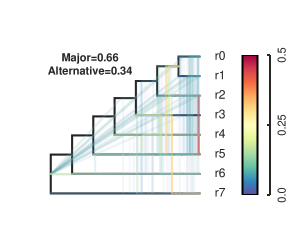

In [305]:
# draw all edges on major networks
c, a, m = IMBTREE.draw(height=250, width=290, admixture_edges=d.plot_admix.to_list(),
                      fixed_order = NAME_ORDER);
# add colorbar
numberline = c.numberline(250, 195, 250, 55, min=0, max=0.5)
numberline.colormap(cmap_snaq, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0.0, 0.25, 0.50], labels=[0.0, 0.25, 0.50])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
# add text major vs. alternative network topology
c.text(90,65,
    "<b>Major=0.66</b><br/><b>Alternative=0.34</b>",
    style={"font-size":"11px"},
);
toyplot.svg.render(c, "./nb12_output/plot-net1genealogies-superset200-variable-ne-1e5-imb.svg")
c

In [306]:
# compute means
hist_major_mean = np.mean(d.gamma[d["gamma"] != 0].values)
hist_minor_mean = np.mean(e.gamma[e["gamma"] != 0].values)
print(hist_major_mean, hist_minor_mean)

0.058791500000000003 0.07048206349206348


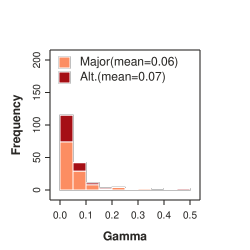

In [307]:
# stacked version
hist_major = np.histogram(d.gamma[d["gamma"] != 0].values, range=(0, 0.5), bins=10)
hist_minor = np.histogram(e.gamma[e["gamma"] != 0].values, range=(0, 0.5), bins=10)
major_minor_stack_counts = np.column_stack((hist_major[0], hist_minor[0]))

c = toyplot.Canvas(width=250, height=250)
a = c.cartesian()
bars = a.bars((major_minor_stack_counts), 
              along="x",
              color=[colors_hist[1], colors2_hist[1]])
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
a.x.ticks.locator = toyplot.locator.Explicit(locations=[-0.5,1.5,3.5,5.5,7.5,9.5], labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
c.style["stroke.width"]=8
a.y.domain.max=200
c.legend([
    ("Major(mean=0.06)", bars.markers[0]),
    ("Alt.(mean=0.07)", bars.markers[1]),
    ],
    bounds=(70, 80, 55, 85),
    );
toyplot.svg.render(c, "./nb12_output/plot-net1genealogies-superset200-hist-gamma-variable-ne-1e5-imb.svg")
c

#### Net 1 raxtrees

In [308]:
a, b, c = parse_networks_tsv(superset_imb_Ne_100000.snaq_net1_raxtrees, cmap_snaq)
d, e, f = count_alt_topology_prop(b, imbtree_ne)
f

0.021621621621621623

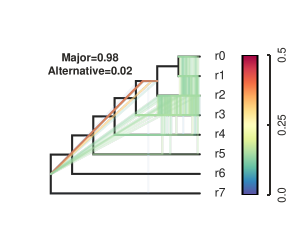

In [309]:
# draw all edges on major networks
c, a, m = IMBTREE.draw(height=250, width=290, admixture_edges=d.plot_admix.to_list(),
                      fixed_order = NAME_ORDER);
# add colorbar
numberline = c.numberline(250, 195, 250, 55, min=0, max=0.5)
numberline.colormap(cmap_snaq, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0.0, 0.25, 0.50], labels=[0.0, 0.25, 0.50])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
# add text major vs. alternative network topology
c.text(90,65,
    "<b>Major=0.98</b><br/><b>Alternative=0.02</b>",
    style={"font-size":"11px"},
);
toyplot.svg.render(c, "./nb12_output/plot-net1raxtrees-superset200-variable-ne-1e5-imb.svg")
c

In [310]:
# compute means
hist_major_mean = np.mean(d.gamma[d["gamma"] != 0].values)
hist_minor_mean = np.mean(e.gamma[e["gamma"] != 0].values)
print(hist_major_mean, hist_minor_mean)

0.14292817679558012 0.19267499999999999


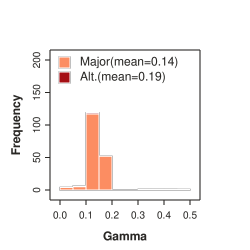

In [311]:
# stacked version
hist_major = np.histogram(d.gamma[d["gamma"] != 0].values, range=(0, 0.5), bins=10)
hist_minor = np.histogram(e.gamma[e["gamma"] != 0].values, range=(0, 0.5), bins=10)
major_minor_stack_counts = np.column_stack((hist_major[0], hist_minor[0]))

c = toyplot.Canvas(width=250, height=250)
a = c.cartesian()
bars = a.bars((major_minor_stack_counts), 
              along="x",
              color=[colors_hist[1], colors2_hist[1]])
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
a.x.ticks.locator = toyplot.locator.Explicit(locations=[-0.5,1.5,3.5,5.5,7.5,9.5], labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
c.style["stroke.width"]=8
a.y.domain.max=200
c.legend([
    ("Major(mean=0.14)", bars.markers[0]),
    ("Alt.(mean=0.19)", bars.markers[1]),
    ],
    bounds=(70, 80, 55, 85),
    );
toyplot.svg.render(c, "./nb12_output/plot-net1raxtrees-superset200-hist-gamma-variable-ne-1e5-imb.svg")
c

#### loglik histogram

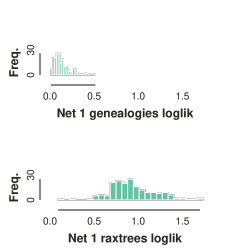

In [339]:
loglik_all = [np.array(superset_imb_Ne_100000.snaq_net1_genealogies_loglik_diff), np.array(superset_imb_Ne_100000.snaq_net1_raxtrees_loglik_diff)]

c = toyplot.Canvas(width=250, height=250)
labels = ["Net 1 genealogies loglik", "Net 1 raxtrees loglik"]
for idx, loglik in enumerate(loglik_all):
    a = c.cartesian(grid=(len(loglik_all), 1, idx))
    a.bars(np.histogram(loglik, 25))
    a.y.ticks.locator = toyplot.locator.Explicit(locations=[0, 30], labels=[0, 30])
    a.x.label.text = labels[idx]
    a.y.label.text = "Freq."
    a.x.domain.max = 1.7
toyplot.svg.render(c, "./nb12_output/plot-net1-superset200-loglik-hist-variable-ne-1e5-imb.svg")   
c


### Imb gt 1000

#### Net 1 genealogies

In [313]:
a, b, c = parse_networks_tsv(superset_imb_gt_1000.snaq_net1_genealogies, cmap_snaq)
d, e, f = count_alt_topology_prop(b, imbtree_gt)
f

0.4230769230769231

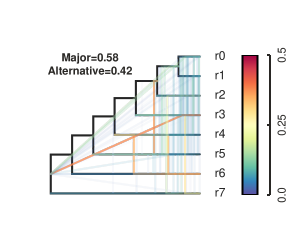

In [314]:
# draw all edges on major networks
c, a, m = IMBTREE.draw(height=250, width=290, admixture_edges=d.plot_admix.to_list(),
                      fixed_order = NAME_ORDER);
# add colorbar
numberline = c.numberline(250, 195, 250, 55, min=0, max=0.5)
numberline.colormap(cmap_snaq, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0.0, 0.25, 0.50], labels=[0.0, 0.25, 0.50])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
# add text major vs. alternative network topology
c.text(90,65,
    "<b>Major=0.58</b><br/><b>Alternative=0.42</b>",
    style={"font-size":"11px"},
);
toyplot.svg.render(c, "./nb12_output/plot-net1genealogies-superset200-variable-gt-1e3-imb.svg")
c

In [315]:
# compute means
hist_major_mean = np.mean(d.gamma[d["gamma"] != 0].values)
hist_minor_mean = np.mean(e.gamma[e["gamma"] != 0].values)
print(hist_major_mean, hist_minor_mean)

0.062192190476190484 0.077772987012987


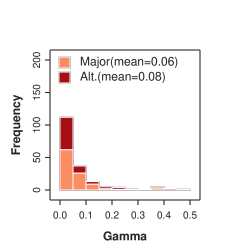

In [316]:
# stacked version
hist_major = np.histogram(d.gamma[d["gamma"] != 0].values, range=(0, 0.5), bins=10)
hist_minor = np.histogram(e.gamma[e["gamma"] != 0].values, range=(0, 0.5), bins=10)
major_minor_stack_counts = np.column_stack((hist_major[0], hist_minor[0]))

c = toyplot.Canvas(width=250, height=250)
a = c.cartesian()
bars = a.bars((major_minor_stack_counts), 
              along="x",
              color=[colors_hist[1], colors2_hist[1]])
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
a.x.ticks.locator = toyplot.locator.Explicit(locations=[-0.5,1.5,3.5,5.5,7.5,9.5], labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
c.style["stroke.width"]=8
a.y.domain.max=200
c.legend([
    ("Major(mean=0.06)", bars.markers[0]),
    ("Alt.(mean=0.08)", bars.markers[1]),
    ],
    bounds=(70, 80, 55, 85),
    );
toyplot.svg.render(c, "./nb12_output/plot-net1genealogies-superset200-hist-gamma-variable-gt-1e3-imb.svg")
c

#### Net 1 raxtrees

In [317]:
a, b, c = parse_networks_tsv(superset_imb_gt_1000.snaq_net1_raxtrees, cmap_snaq)
d, e, f = count_alt_topology_prop(b, imbtree_gt)
f

0.37362637362637363

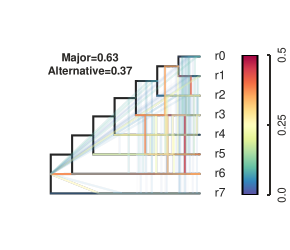

In [318]:
# draw all edges on major networks
c, a, m = IMBTREE.draw(height=250, width=290, admixture_edges=d.plot_admix.to_list(),
                      fixed_order = NAME_ORDER);
# add colorbar
numberline = c.numberline(250, 195, 250, 55, min=0, max=0.5)
numberline.colormap(cmap_snaq, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0.0, 0.25, 0.50], labels=[0.0, 0.25, 0.50])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
# add text major vs. alternative network topology
c.text(90,65,
    "<b>Major=0.63</b><br/><b>Alternative=0.37</b>",
    style={"font-size":"11px"},
);
toyplot.svg.render(c, "./nb12_output/plot-net1raxtrees-superset200-variable-gt-1e3-imb.svg")
c

In [319]:
# compute means
hist_major_mean = np.mean(d.gamma[d["gamma"] != 0].values)
hist_minor_mean = np.mean(e.gamma[e["gamma"] != 0].values)
print(hist_major_mean, hist_minor_mean)

0.08800210526315788 0.1247785294117647


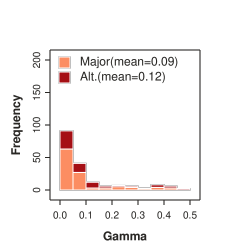

In [320]:
# stacked version
hist_major = np.histogram(d.gamma[d["gamma"] != 0].values, range=(0, 0.5), bins=10)
hist_minor = np.histogram(e.gamma[e["gamma"] != 0].values, range=(0, 0.5), bins=10)
major_minor_stack_counts = np.column_stack((hist_major[0], hist_minor[0]))

c = toyplot.Canvas(width=250, height=250)
a = c.cartesian()
bars = a.bars((major_minor_stack_counts), 
              along="x",
              color=[colors_hist[1], colors2_hist[1]])
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
a.x.ticks.locator = toyplot.locator.Explicit(locations=[-0.5,1.5,3.5,5.5,7.5,9.5], labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
c.style["stroke.width"]=8
a.y.domain.max=200
c.legend([
    ("Major(mean=0.09)", bars.markers[0]),
    ("Alt.(mean=0.12)", bars.markers[1]),
    ],
    bounds=(70, 80, 55, 85),
    );
toyplot.svg.render(c, "./nb12_output/plot-net1raxtrees-superset200-hist-gamma-variable-gt-1e3-imb.svg")
c

#### loglik histogram

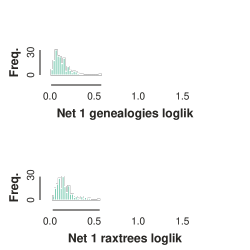

In [341]:
loglik_all = [np.array(superset_imb_gt_1000.snaq_net1_genealogies_loglik_diff), np.array(superset_imb_gt_1000.snaq_net1_raxtrees_loglik_diff)]

c = toyplot.Canvas(width=250, height=250)
labels = ["Net 1 genealogies loglik", "Net 1 raxtrees loglik"]
for idx, loglik in enumerate(loglik_all):
    a = c.cartesian(grid=(len(loglik_all), 1, idx))
    a.bars(np.histogram(loglik, 25))
    a.y.ticks.locator = toyplot.locator.Explicit(locations=[0, 30], labels=[0, 30])
    a.x.label.text = labels[idx]
    a.y.label.text = "Freq."
    a.x.domain.max = 1.7
toyplot.svg.render(c, "./nb12_output/plot-net1-superset200-loglik-hist-variable-gt-1e3-imb.svg")   
c


### Imb gt 100000

#### Net 1 genealogies

In [323]:
a, b, c = parse_networks_tsv(superset_imb_gt_100000.snaq_net1_genealogies, cmap_snaq)
d, e, f = count_alt_topology_prop(b, imbtree_gt)
f

0.350253807106599

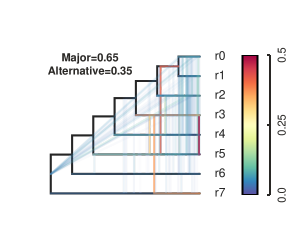

In [324]:
# draw all edges on major networks
c, a, m = IMBTREE.draw(height=250, width=290, admixture_edges=d.plot_admix.to_list(),
                      fixed_order = NAME_ORDER);
# add colorbar
numberline = c.numberline(250, 195, 250, 55, min=0, max=0.5)
numberline.colormap(cmap_snaq, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0.0, 0.25, 0.50], labels=[0.0, 0.25, 0.50])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
# add text major vs. alternative network topology
c.text(90,65,
    "<b>Major=0.65</b><br/><b>Alternative=0.35</b>",
    style={"font-size":"11px"},
);
toyplot.svg.render(c, "./nb12_output/plot-net1genealogies-superset200-variable-gt-1e5-imb.svg")
c

In [325]:
# compute means
hist_major_mean = np.mean(d.gamma[d["gamma"] != 0].values)
hist_minor_mean = np.mean(e.gamma[e["gamma"] != 0].values)
print(hist_major_mean, hist_minor_mean)

0.049482421875 0.10236057971014492


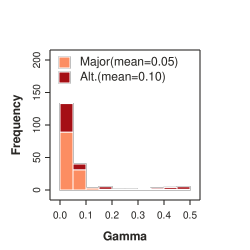

In [326]:
# stacked version
hist_major = np.histogram(d.gamma[d["gamma"] != 0].values, range=(0, 0.5), bins=10)
hist_minor = np.histogram(e.gamma[e["gamma"] != 0].values, range=(0, 0.5), bins=10)
major_minor_stack_counts = np.column_stack((hist_major[0], hist_minor[0]))

c = toyplot.Canvas(width=250, height=250)
a = c.cartesian()
bars = a.bars((major_minor_stack_counts), 
              along="x",
              color=[colors_hist[1], colors2_hist[1]])
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
a.x.ticks.locator = toyplot.locator.Explicit(locations=[-0.5,1.5,3.5,5.5,7.5,9.5], labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
c.style["stroke.width"]=8
a.y.domain.max=200
c.legend([
    ("Major(mean=0.05)", bars.markers[0]),
    ("Alt.(mean=0.10)", bars.markers[1]),
    ],
    bounds=(70, 80, 55, 85),
    );
toyplot.svg.render(c, "./nb12_output/plot-net1genealogies-superset200-hist-gamma-variable-gt-1e5-imb.svg")
c

#### Net 1 raxtrees

In [327]:
a, b, c = parse_networks_tsv(superset_imb_gt_100000.snaq_net1_raxtrees, cmap_snaq)
d, e, f = count_alt_topology_prop(b, imbtree_gt)
f

0.49230769230769234

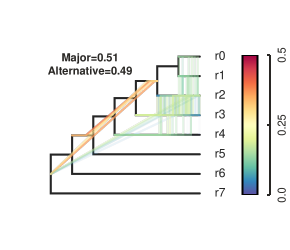

In [328]:
# draw all edges on major networks
c, a, m = IMBTREE.draw(height=250, width=290, admixture_edges=d.plot_admix.to_list(),
                      fixed_order = NAME_ORDER);
# add colorbar
numberline = c.numberline(250, 195, 250, 55, min=0, max=0.5)
numberline.colormap(cmap_snaq, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0.0, 0.25, 0.50], labels=[0.0, 0.25, 0.50])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
# add text major vs. alternative network topology
c.text(90,65,
    "<b>Major=0.51</b><br/><b>Alternative=0.49</b>",
    style={"font-size":"11px"},
);
toyplot.svg.render(c, "./nb12_output/plot-net1raxtrees-superset200-variable-gt-1e5-imb.svg")
c

In [329]:
# compute means
hist_major_mean = np.mean(d.gamma[d["gamma"] != 0].values)
hist_minor_mean = np.mean(e.gamma[e["gamma"] != 0].values)
print(hist_major_mean, hist_minor_mean)

0.13019292929292928 0.110996875


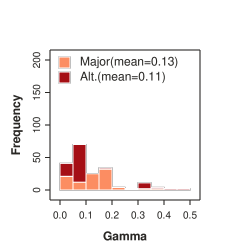

In [330]:
# stacked version
hist_major = np.histogram(d.gamma[d["gamma"] != 0].values, range=(0, 0.5), bins=10)
hist_minor = np.histogram(e.gamma[e["gamma"] != 0].values, range=(0, 0.5), bins=10)
major_minor_stack_counts = np.column_stack((hist_major[0], hist_minor[0]))

c = toyplot.Canvas(width=250, height=250)
a = c.cartesian()
bars = a.bars((major_minor_stack_counts), 
              along="x",
              color=[colors_hist[1], colors2_hist[1]])
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
a.x.ticks.locator = toyplot.locator.Explicit(locations=[-0.5,1.5,3.5,5.5,7.5,9.5], labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
c.style["stroke.width"]=8
a.y.domain.max=200
c.legend([
    ("Major(mean=0.13)", bars.markers[0]),
    ("Alt.(mean=0.11)", bars.markers[1]),
    ],
    bounds=(70, 80, 55, 85),
    );
toyplot.svg.render(c, "./nb12_output/plot-net1raxtrees-superset200-hist-gamma-variable-gt-1e5-imb.svg")
c

#### loglik histogram

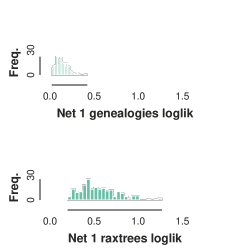

In [342]:
loglik_all = [np.array(superset_imb_gt_100000.snaq_net1_genealogies_loglik_diff), np.array(superset_imb_gt_100000.snaq_net1_raxtrees_loglik_diff)]

c = toyplot.Canvas(width=250, height=250)
labels = ["Net 1 genealogies loglik", "Net 1 raxtrees loglik"]
for idx, loglik in enumerate(loglik_all):
    a = c.cartesian(grid=(len(loglik_all), 1, idx))
    a.bars(np.histogram(loglik, 25))
    a.y.ticks.locator = toyplot.locator.Explicit(locations=[0, 30], labels=[0, 30])
    a.x.label.text = labels[idx]
    a.y.label.text = "Freq."
    a.x.domain.max = 1.7
toyplot.svg.render(c, "./nb12_output/plot-net1-superset200-loglik-hist-variable-gt-1e5-imb.svg")   
c


## Gamma vs. loglik correlation plot

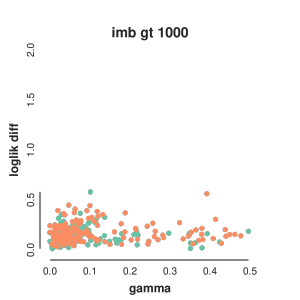

In [615]:
# imb gt 1000
a1, b1, c1 = parse_networks_tsv(superset_imb_gt_1000.snaq_net1_genealogies, cmap_snaq)
a2, b2, c2 = parse_networks_tsv(superset_imb_gt_1000.snaq_net1_raxtrees, cmap_snaq)
c = toyplot.Canvas(width=300, height=300)
a = c.cartesian(label="imb gt 1000", xlabel="gamma", ylabel="loglik diff")
m1 = a.scatterplot(a1.gamma, superset_imb_gt_1000.snaq_net1_genealogies_loglik_diff)
m2 = a.scatterplot(a2.gamma, superset_imb_gt_1000.snaq_net1_raxtrees_loglik_diff)
a.y.domain.max = 2.0
c

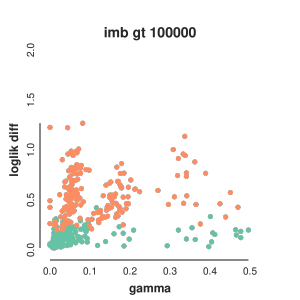

In [614]:
# imb gt 100000
a1, b1, c1 = parse_networks_tsv(superset_imb_gt_100000.snaq_net1_genealogies, cmap_snaq)
a2, b2, c2 = parse_networks_tsv(superset_imb_gt_100000.snaq_net1_raxtrees, cmap_snaq)
c = toyplot.Canvas(width=300, height=300)
a = c.cartesian(label="imb gt 100000", xlabel="gamma", ylabel="loglik diff")
m1 = a.scatterplot(a1.gamma, superset_imb_gt_100000.snaq_net1_genealogies_loglik_diff)
m2 = a.scatterplot(a2.gamma, superset_imb_gt_100000.snaq_net1_raxtrees_loglik_diff)
a.y.domain.max = 2.0
c

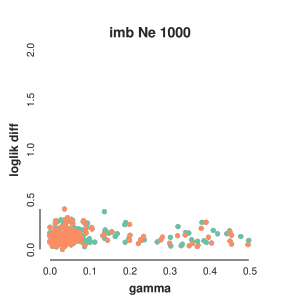

In [613]:
# imb Ne 1000
a1, b1, c1 = parse_networks_tsv(superset_imb_Ne_1000.snaq_net1_genealogies, cmap_snaq)
a2, b2, c2 = parse_networks_tsv(superset_imb_Ne_1000.snaq_net1_raxtrees, cmap_snaq)
c = toyplot.Canvas(width=300, height=300)
a = c.cartesian(label="imb Ne 1000", xlabel="gamma", ylabel="loglik diff")
m1 = a.scatterplot(a1.gamma, superset_imb_Ne_1000.snaq_net1_genealogies_loglik_diff)
m2 = a.scatterplot(a2.gamma, superset_imb_Ne_1000.snaq_net1_raxtrees_loglik_diff)
a.y.domain.max = 2.0
c

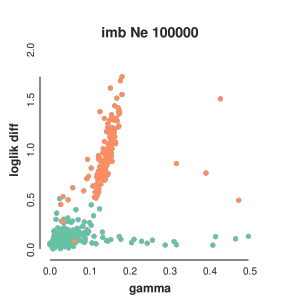

In [612]:
# imb Ne 100000
a1, b1, c1 = parse_networks_tsv(superset_imb_Ne_100000.snaq_net1_genealogies, cmap_snaq)
a2, b2, c2 = parse_networks_tsv(superset_imb_Ne_100000.snaq_net1_raxtrees, cmap_snaq)
canvas = toyplot.Canvas(width=300, height=300)
ax1 = canvas.cartesian(label="imb Ne 100000", xlabel="gamma", ylabel="loglik diff")
mark1 = ax1.scatterplot(a1.gamma, superset_imb_Ne_100000.snaq_net1_genealogies_loglik_diff)
mark2 = ax1.scatterplot(a2.gamma, superset_imb_Ne_100000.snaq_net1_raxtrees_loglik_diff)
ax1.y.domain.max = 2.0
canvas

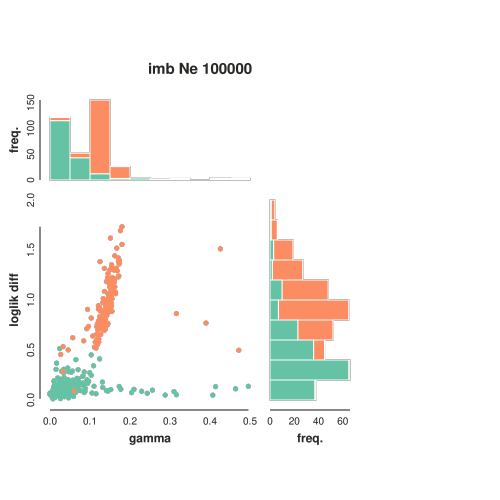

In [616]:
# imb Ne 100000
a1, b1, c1 = parse_networks_tsv(superset_imb_Ne_100000.snaq_net1_genealogies, cmap_snaq)
a2, b2, c2 = parse_networks_tsv(superset_imb_Ne_100000.snaq_net1_raxtrees, cmap_snaq)
canvas = toyplot.Canvas(width=500, height=500)
ax1 = canvas.cartesian(xlabel="gamma", ylabel="loglik diff", bounds=(50, 250, 200, 400))
mark1 = ax1.scatterplot(a1.gamma, superset_imb_Ne_100000.snaq_net1_genealogies_loglik_diff)
mark2 = ax1.scatterplot(a2.gamma, superset_imb_Ne_100000.snaq_net1_raxtrees_loglik_diff)
ax1.y.domain.max = 2.0

ax2 = canvas.cartesian(bounds=(270, 350, 200, 400), xlabel="freq.")
genealogies = np.histogram(superset_imb_Ne_100000.snaq_net1_genealogies_loglik_diff, bins=10)
gene_trees = np.histogram(superset_imb_Ne_100000.snaq_net1_raxtrees_loglik_diff, bins=10)
genealogies_gene_trees_stack = np.column_stack((genealogies[0], gene_trees[0]))
mark3 = ax2.bars(genealogies_gene_trees_stack, along="y", color=[colors[0], colors[1]])
ax2.y.show = False

ax3 = canvas.cartesian(bounds=(50, 250, 100, 180), ylabel="freq.")
genealogies_gamma = np.histogram(a1.gamma, bins=10)
gene_trees_gamma = np.histogram(a2.gamma, bins=10)
genealogies_gene_trees_gamma_stack = np.column_stack((genealogies_gamma[0], gene_trees_gamma[0]))
mark4 = ax3.bars(genealogies_gene_trees_gamma_stack, along="x", color=[colors[0], colors[1]])
ax3.x.show = False

canvas.text(200, 70, text="<b>imb Ne 100000</b>", style={"font-size":"15px"})
canvas

## Astral tree error

In [625]:
# color palette
colors = toyplot.color.brewer.palette("Set2")
colors

In [617]:
def concat_dist(concat_trees, true_sptree):
    rfs = []
    for concat_tree in concat_trees:
        c_tree = toytree.tree(concat_tree)
        rf = toytree.distance.get_treedist_rf(c_tree, true_sptree)
        rfs.append(rf)
    return rfs

In [620]:
rf_imb_gt_1000 = concat_dist(superset_imb_gt_1000.concat_tree_raxml, imbtree_gt)
rf_imb_gt_100000 = concat_dist(superset_imb_gt_100000.concat_tree_raxml, imbtree_gt)
rf_imb_Ne_1000 = concat_dist(superset_imb_gt_1000.concat_tree_raxml, imbtree_gt)
rf_imb_Ne_100000 = concat_dist(superset_imb_gt_100000.concat_tree_raxml, imbtree_gt)

error_rate_imb_gt_1000_concat = check_error_rate(rf_imb_gt_1000)
error_rate_imb_gt_100000_concat = check_error_rate(rf_imb_gt_100000)
error_rate_imb_ne_1000_concat = check_error_rate(rf_imb_Ne_1000)
error_rate_imb_ne_100000_concat = check_error_rate(rf_imb_Ne_100000)

In [452]:
def check_error_rate(input_col):
    errors = []
    for dist in input_col:
        if(dist == 0):
                errors.append(0)
        else:
            errors.append(1)
    error_rate = sum(errors)/len(errors)
    
    return error_rate

In [462]:
error_rate_imb_gt_1000_genealogies = check_error_rate(superset_imb_gt_1000.dist_astral_tree_genealogies)
error_rate_imb_gt_100000_genealogies = check_error_rate(superset_imb_gt_100000.dist_astral_tree_genealogies)
error_rate_imb_ne_1000_genealogies = check_error_rate(superset_imb_Ne_1000.dist_astral_tree_genealogies)
error_rate_imb_ne_100000_genealogies = check_error_rate(superset_imb_Ne_100000.dist_astral_tree_genealogies)

error_rate_imb_gt_1000_raxml_gene_trees = check_error_rate(superset_imb_gt_1000.dist_astral_tree_raxtrees)
error_rate_imb_gt_100000_raxml_gene_trees = check_error_rate(superset_imb_gt_100000.dist_astral_tree_raxtrees)
error_rate_imb_ne_1000_raxml_gene_trees = check_error_rate(superset_imb_Ne_1000.dist_astral_tree_raxtrees)
error_rate_imb_ne_100000_raxml_gene_trees = check_error_rate(superset_imb_Ne_100000.dist_astral_tree_raxtrees)

In [621]:
data_dist = np.array([error_rate_imb_ne_1000_concat, error_rate_imb_gt_1000_concat,
                      error_rate_imb_ne_100000_concat, error_rate_imb_gt_100000_concat,
                      error_rate_imb_ne_1000_genealogies, error_rate_imb_gt_1000_genealogies, 
                      error_rate_imb_ne_1000_raxml_gene_trees, error_rate_imb_gt_1000_raxml_gene_trees, 
                      error_rate_imb_ne_100000_genealogies, error_rate_imb_gt_100000_genealogies, 
                      error_rate_imb_ne_100000_raxml_gene_trees, error_rate_imb_gt_100000_raxml_gene_trees])
data_dist

array([1.        , 1.        , 1.        , 1.        , 0.31313131,
       0.27173913, 0.4040404 , 0.31521739, 0.31891892, 0.28140704,
       0.03243243, 0.52261307])

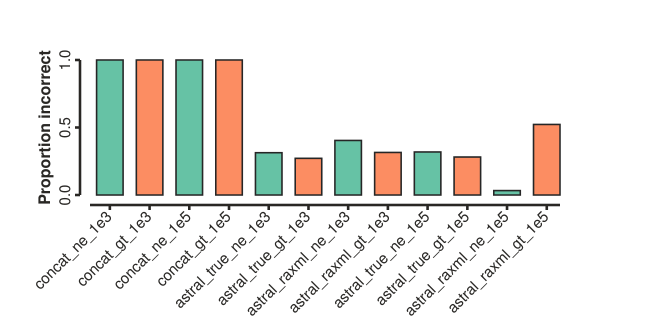

In [628]:
canvas = toyplot.Canvas(width=650, height=325)
axes = canvas.cartesian(bounds=(80, -80, 50, -120))
axes.x.ticks.locator = toyplot.locator.Explicit(np.arange(data_dist.size) + 0.5, )
axes.x.spine.style["stroke-width"] = 2.5
axes.x.ticks.style["stroke-width"] = 2.5
axes.x.ticks.labels.style["font-size"] = 15
axes.x.label.style["font-size"] = 16
axes.x.domain.min = 0
axes.x.ticks.locator = toyplot.locator.Explicit(
    locations=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5],
    labels=["concat_ne_1e3", "concat_gt_1e3",
            "concat_ne_1e5", "concat_gt_1e5",
            "astral_true_ne_1e3", "astral_true_gt_1e3", 
            "astral_raxml_ne_1e3", "astral_raxml_gt_1e3", 
            "astral_true_ne_1e5", "astral_true_gt_1e5", 
            "astral_raxml_ne_1e5", "astral_raxml_gt_1e5"])
axes.x.ticks.labels.angle = 45

axes.y.label.text = "Proportion incorrect"
axes.y.spine.style["stroke-width"] = 2.5
axes.y.ticks.style["stroke-width"] = 2.5
axes.y.ticks.labels.style["font-size"] = 15
axes.y.ticks.labels.style["font-size"] = 15
axes.y.label.style["font-size"] = 16
axes.y.domain.max = 1.0

starts = np.arange(data_dist.size) + 1/6
mark = axes.bars(
    starts, 
    starts + 4/6,
    data_dist,
    style={"stroke": "#262626", 
           "stroke-width": 1.5},
    color=[colors[0], colors[1], colors[0], colors[1], colors[0], colors[1], colors[0], colors[1], colors[0], colors[1], colors[0], colors[1]]
)

toytree.utils.set_axes_ticks_external(axes);
#toyplot.svg.render(canvas, "./nb7_output/astral-error-rate-plot-rfg-mci-absolute.svg")
# toytree.utils.set_axes_box_outline(axes);
canvas